# Generování textu znakovou RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm

import torch
import torch.nn.functional as F
from torch import nn

import ans

V tomto cvičení nebudeme používat GPU, protože budeme zpracovávat znaky po jednom a v takto malých dávkách overhead způsobený neustálými přesuny dat mezi GPU a RAM výpočty pouze zpomalí.

# Data

Namísto obrazu tentokrát použijeme textová data. Konkrétně se jedná o novinové nadpisy, které se budeme snažit generovat automaticky. Všechna data jsou v jediném souboru `data/headlines.txt`.

Z textu byly odstraněny háčky, čárky a všechny nestandardní znaky. Není tedy potřeba řešit kódování apod.

In [2]:
data = open('data/articles_idnes.txt').read()
lines = [line for line in data.split('\n') if line]

Ukázka dat:

In [3]:
for i in range(10):
    print(i, random.choice(lines))

0 nenechte sve pocitace zahalet ani po tom co covid19 prestane byt tema
1 karlovy vary spustily slevove poukazy k pobytu prilakaly prvni turisty
2 unikat v dansku fotbal o divaky neprijde zafandi pres videohovor
3 hollywood hleda odborniky na covid19 chce se postarat o zdravi stabu
4 staleta semtinska lipa padla v bouri pred 20 lety uz ma nasledovnice
5 ceny pohonnych hmot se odrazily ode dna za 26 korun je uz i nafta
6 renaultnissanmitsubishi ma novou strategii bude vice sdilet techniku
7 dcera nosi i v peti a pul letech pleny priznala kristen bellova
8 bryantovo uvedeni do basketbalove sine slavy se odklada na pristi rok
9 jako v exotice dodejte satniku vasnivy vzruch jiznich krajin


Sada znaků = náš slovník:

In [4]:
chars = list(sorted(set(data)))
print(len(chars), chars)

38 ['\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Všimněme si, že první znak je `'\n'`. Ten použijeme jako stop znak, neboli speciální token, jenž bude označovat konec sekvence. Pokud tedy při postupném generování věty dojde na tento znak, proces zastavíme.

Následující tabulka (`dict`) nám usnadní převod znaku na index.

In [5]:
chr2idx = {c: i for i, c in enumerate(chars)}

Podíváme se na statistické rozložení prvních znaků ve větách.

In [6]:
counts = {c: 0 for c in chars}
for line in lines:
    counts[line[0]] += 1
counts = np.array([counts[c] for c in chars], dtype=np.float)
p0 = counts / counts.sum()

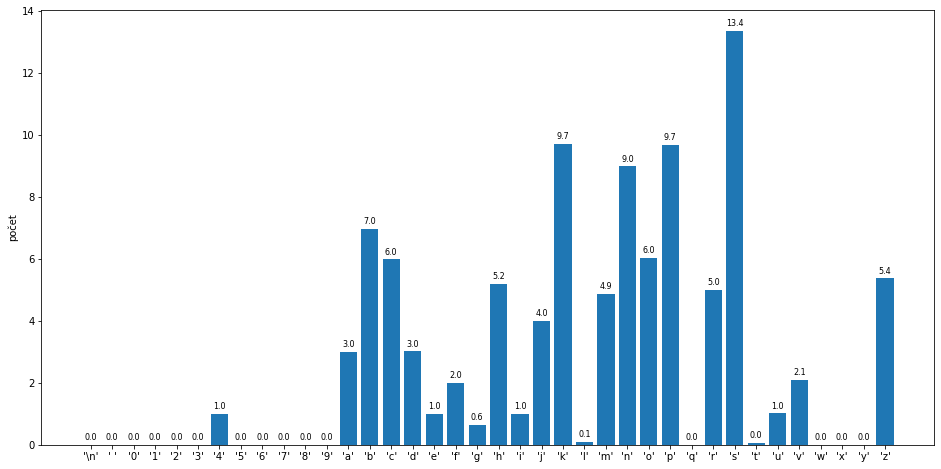

In [7]:
plt.figure(figsize=(16, 8))
rects = plt.bar(range(len(chars)), 100. * p0)
plt.xticks(range(len(chars)), ['{}'.format(repr(c)) for c in chars])
for r in rects:
    x, w, h = r.get_x(), r.get_width(), r.get_height()
    plt.text(x + w / 2., h + 0.1, '{:.1f}'.format(h), ha='center', va='bottom', fontsize=8)
plt.ylabel('počet');

# Sekvenční data a PyTorch

## Embedding

Následující funkce `str2idt` převede řetězec na sekvenci čísel (index tensor) odpovídajících indexům znaků v tabulce. Pokud např. bude celý náš "slovník" `chars = ['a', 'b', 'c']`, pak funkce `str2idt` převede řetězec `'acba'` na `[0, 2, 1, 0]`. Výsledek vrátí jako PyTorch `torch.Tensor`.

In [8]:
def str2idt(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = chr2idx[string[c]]
    return tensor

In [9]:
# nas slovnik ma 38 znaku, takze indexy znaku budou jine
x = str2idt('abca')
x

tensor([12, 13, 14, 12])

Další funkce bude dělat opak: převede sekvenci indexů na řetězec.

In [10]:
def idt2str(indices):
    return ''.join([chars[i] for i in indices])

In [11]:
idt2str(x)

'abca'

Sekvenci čísel potřebujeme převést na vektory jednotlivých znaků. Tento proces se v anglické literatuře označuje jako embedding a PyTorch ho implementuje jako vrstvu třídou `Embedding`. Vyjádřením této operace diferencovatelnou vrstvou umožňuje učení vektorů, které tedy nemusejí být fixní. O tom ale až příště.

In [12]:
# velikost slovniku je `len(chars)`
# dimenze znakoveho vektoru bude napr. 30
emb = nn.Embedding(len(chars), 30)

# dopredny pruchod
e = emb(x)
e.shape

torch.Size([4, 30])

In [13]:
e

tensor([[-1.1967,  0.5725,  0.5710,  0.8383, -0.2425,  0.9054,  0.1555,  0.3322,
          1.0109,  0.0747, -0.3960, -0.0312,  0.2078,  0.1894,  0.1636, -1.6672,
          0.0462, -0.7272, -0.1340,  0.9464,  1.1265, -0.1289,  0.4292, -0.6476,
          0.3500,  0.4063, -0.0824,  0.8458,  2.3992, -0.5224],
        [ 0.5487, -0.1005,  1.7837,  0.4001,  1.5281,  1.1759,  1.2375, -1.7446,
          0.4003, -0.2616,  0.2982, -1.1134,  0.1056, -1.0955, -1.7892, -0.5743,
         -0.8006,  0.9264,  0.2051, -0.3316,  1.8038,  0.9181, -1.6186, -1.3353,
          0.1247, -1.5828,  0.5807,  1.5234, -1.1902,  0.0271],
        [ 0.5302, -0.6445, -0.4202, -0.9742,  0.3426,  0.2791,  0.0535,  1.6108,
         -0.3918,  0.6923,  1.3579, -1.1531,  2.3927, -0.6568,  0.5957, -2.3961,
         -0.6839, -0.0955,  0.2718,  0.3639, -0.3375, -0.6205, -0.8508, -0.3297,
          1.7003,  0.2139, -0.1535, -0.3760, -1.3379, -0.2178],
        [-1.1967,  0.5725,  0.5710,  0.8383, -0.2425,  0.9054,  0.1555,  0.3322

`Embedding` nedělá nic jiného, než že na výstup pro znak s indexem $i$ vrátí $i$-tý řádek své váhové matice `weight`, která drží vektory slov. Defaultně je tato matice inicializována náhodně. Pokud první písmeno v příkladu bylo 'a', jehož index ve "slovníku" `chars` je 12, první řádek embeddingu `e` bude odpovídat 13. řádku (index 12) matice `emb.weight`.

In [14]:
bool(torch.all(e[0] == emb.weight[12]))

True

## RNN v PyTorch

PyTorch implementuje tři z nejrozšířenějších typů sítí třídami `RNN`, `LSTM` a `GRU`. API je pro všechny stejné: dopředný průchod `forward` očekává "zespodu" nějaký vstup `input` a "zleva" minulý stav `h0`. U `LSTM` je tento stav dvouvektorový. Výstupem je `output`, což je vlastně sekvence skrytých stavů poslední vrstvy rekurentní sítě pro jednotlivé kroky v čase, a nový stav `hn` po provedení celého průchodu. Vše vystihuje následující obrázek.

![](https://i.stack.imgur.com/SjnTl.png)

Zdroj: https://stackoverflow.com/a/48305882/9418551

V nejjednoušším případě máme pouze jednu vrstvu sítě a jeden krok. Potom `output` a `hn` jsou stejné. To znamená, že `output` **neprochází žádnou lineární vrstvou**, jak jsme si to ukazovali na přednáškách, tedy že $y=W^{hy}h$, kde $y$ značí `output`. Transformaci na skóre/pravděpodobnost jednotlivých znaků tedy musíme provést sami. Parametry $W^{hy}$ RNN v PyTorch nezahrnují.

Vstupní tensory $x_i$ na obrázku očekávají PyTorch RNN ve tvaru `(seq, batch, dim)`, kde
- `seq` ... jak jdou znaky ve "věte" za sebou
- `batch` ... počet paralelně zpracovávaných sekvencí, nezávisle na sobě
- `dim` ... příznaky na vstupu

V našem případě jsou vstupy vektory (embeddingy) jednotlivých znaků. Například tedy: `(10, 3, 5)` by znamenalo:
- 3 paralelně zpracovávané
- 10-znakové věty,
- kde každý znak reprezentuje 5dimenzionální vektor

In [15]:
# do site posleme pouze jeden znak; tvar tensoru musi byt (seq, batch, dim), proto musime pouzit reshape
print(e[0].shape)
e0 = e[0].reshape(1, 1, -1)
e0.shape

torch.Size([30])


torch.Size([1, 1, 30])

Vytvoříme jednuduchou `torch.nn.RNN`, která na vstupu očekává vektor o rozměru 30 a bude mít skrytý vektor o rozměru 8.

In [16]:
rnn = nn.RNN(30, 8)
rnn

RNN(30, 8)

V PyTorch musíme řešit inicializaci i předávání skrytého stavu v jednotlivých krocích ručně. Umožňuje to tak větší flexibilitu.

In [17]:
# inicializace skryteho stavu a vstupu
# tensory opet musi byt tvaru (seq, batch, dim)
h = torch.rand(1, 1, 8)
h

tensor([[[0.9641, 0.1279, 0.8871, 0.9699, 0.2414, 0.4798, 0.5128, 0.0174]]])

In [18]:
# dopredny pruchod
o, h = rnn(e0, h)

RNN vrátí vždy dvojici `(output, hidden)`, které vysvětluje obrázek výše. V tomto jednoduchém případě, kdy máme pouze jedinou vrstvu, se jedná o tensory se shodnými hodnotami.

In [19]:
bool(torch.all(o == h))

True

Nyní už více samostatně. Zadefinujeme vlastní třídu, která bude řešit jednotlivé kroky sama ve svém dopředném průchodu. Vstupem tedy bude sekvence čísel, výstupem skóre jednotlivých kroků.

In [20]:
test1 = [[1, 2, 3],[1, 2, 3]]
test1 = torch.tensor(test1)
test1.reshape(6, 1)

tensor([[1],
        [2],
        [3],
        [1],
        [2],
        [3]])

In [21]:
class CharRNN(nn.Module):
    def __init__(self, voc_size, emb_dim, hidden_size, output_size, num_layers=1):
        super().__init__()

        #################################################################
        # ZDE DOPLNIT
        
        self.emb = nn.Embedding(voc_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_size, num_layers=num_layers, dropout=0.1)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.hid_s = hidden_size
        self.nm_lay = num_layers
        
        self.reset_hidden()
         
        
        #################################################################

    def forward(self, x):
        
        #################################################################
        # ZDE DOPLNIT
        
        temp = self.emb(x)
        
        temp_shape = temp.shape
        temp = temp.reshape(temp_shape[0], 1, -1)
        
        temp, self.hidden = self.rnn(temp, self.hidden)
        
        score = self.fc(temp)
        
        #################################################################
        
        return score

    def reset_hidden(self):
        
        #################################################################
        # ZDE DOPLNIT
        # funkce resetuje hidden state na nuly
        zero_tens = torch.zeros(self.nm_lay, 1, self.hid_s)
        self.hidden = (zero_tens, zero_tens)
        
        #################################################################

In [22]:
#################################################################
# ZDE DOPLNIT

voc_size = len(chars)
emb_dim = 128
hidden_dim = 1024
output_dim =len(chars)

#################################################################

rnn = CharRNN(voc_size, emb_dim, hidden_dim, output_dim, num_layers=1)
stats = ans.Stats()

C:\Users\Jachym\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Vytvoříme si také funkci pro samplování z naší sítě. Funkce přijme model `rnn` a nějaký inicializační text `init_text` a vygeneruje text - vrací tedy string.

In [23]:
a = torch.randn(4, 1)
print(a)
ind = torch.max(a, 0)[1]
ind = int(ind)
ind

tensor([[ 1.2158],
        [-0.6442],
        [-1.4681],
        [-2.1316]])


0

In [24]:
def sample(rnn, init_text='', maxlen=150, mode='multinomial', temperature=0.6):
    """
    generuje text pomoci modelu `rnn`
    
    vstupy:
        rnn ... rekurentni sit odvozena z `nn.Module`, ktera po zavolani vraci dvojici (vyst_skore, skryta_rep)
        init_text ... inicializacni text, na ktery generovani textu navaze
        maxlen ... maximalni delka generovaneho textu
        mode ... zpusob vyberu nasledujiciho znaku, viz komentare v kodu
        temperature ... vyhlazeni multinomialniho rozlozeni, viz komentare v kodu
    """
    # vystupni text bude pole (na konci prevedeme zpet na str)
    out_text = list(init_text)
    
    # pokud nezadan, inicializujeme nahodne, dle rozlozeni prvnich znaku
    if not out_text:
        k = np.random.choice(len(chars), p=p0)
        out_text = [chars[k]]
    
    # vstup projedeme siti, abychom ziskali aktualni hidden stav
    rnn.reset_hidden()
    if len(out_text) > 1:
        x = str2idt(out_text[:-1])
        score = rnn(x)
    
    # pravdepodobnosti muzeme pocitat softmaxem
    softmax = nn.Softmax(dim=2)

    while True:
        # nasledujici znak je posledni znak prozatimniho vystupu
        x = str2idt(out_text[-1])
        
        # dopredny pruchod
        score = rnn(x)
        
        # pravdepodobnosti znaku
        prob = softmax(score).flatten()
        
        # vyberem index `k` nasleduciho znaku
        if mode == 'multinomial':
            # nasledujici znak bude vybran dle ad hoc multinomialniho rozlozeni
            # parametr `temperature` ... vyssi hodnota znamena nahodnejsi vysledky
            # viz https://github.com/karpathy/char-rnn#sampling
            k = torch.multinomial(score.flatten().div(temperature).exp(), 1)[0]
        elif mode == 'argmax':
            #################################################################
            # ZDE DOPLNIT
            
            # nasledujici znak bude ten, jehoz pravdepodobnost vysla maximalni
            val, ind = torch.max(prob, 0)
            ind = int(ind)
            k = ind
            
            #################################################################
        elif mode == 'proportional':
            #################################################################
            # ZDE DOPLNIT
            
            # nasl. znak se vybere nahodne, ale s pravdepodobnosti proporcionalni k vystupu softmaxu
            # napr. pokud znak 'x' ma dle softmaxu 84 %, bude s pravdepodobnosti 84 % vybran jako vstup do dalsi iterace
            arr_len = len( prob.flatten() )
            rand_choice = np.random.choice(arr_len, 1, p = prob.numpy())
            k = rand_choice
            
            #################################################################
        
        #################################################################
        # ZDE DOPLNIT
        
        # zastavit, pokud end-token
        if chars[k] == '\n':
            break
        
        # pridat znak na vystup
        out_text.append(chars[k])
        
        # zastavit, pokud text je moc dlouhy
        if  len(out_text) >= maxlen:
            break
        
        #################################################################
    
    return ''.join(out_text)

In [25]:
print(sample(rnn, init_text='prezident', mode='multinomial'))

prezidentpzta945xda0kkf5u4e2fdm2nxnrmy99x0z67wpgc ye 971l72uos5hje14n6ag654jpujk8hhk1usa23v58wevss50qqn


# Trénování

V každé iteraci pomocí funkce `char_tensor` vytvoříme trénovací data `(inpt, targ)`, což budou číselné indexy znaků tak, jak je definuje tabulka `chr2idx`. Budeme trénovat generování znaků, tzn. že požadovaným výstupem (label, target) `targ[i]` pro vstup `inpt[i]` je vždy následující znak `inpt[i+1]`. Vektor `targ` je tedy v tomto případě stejného rozměru jako `inpt`. Nezapomeňte na poslední znak, který má jako target `\n` značící konec sekvence.

Vyzkoušejte si na příkladu:

In [26]:
line = random.choice(lines)
print(line)

recept dne jarni polevka s kurecimi knedlicky s parmazanem


In [27]:
#################################################################
# ZDE DOPLNIT

ind_line = str2idt(line)
ind_end = str2idt('\n')

inpt = torch.cat((ind_line[:-1], ind_end), 0)
targ = torch.cat((ind_line[1:], ind_end), 0)

print(inpt)
print(targ.view(-1).long())

#################################################################

tensor([29, 16, 14, 16, 27, 31,  1, 15, 25, 16,  1, 21, 12, 29, 25, 20,  1, 27,
        26, 23, 16, 33, 22, 12,  1, 30,  1, 22, 32, 29, 16, 14, 20, 24, 20,  1,
        22, 25, 16, 15, 23, 20, 14, 22, 36,  1, 30,  1, 27, 12, 29, 24, 12, 37,
        12, 25, 16,  0])
tensor([16, 14, 16, 27, 31,  1, 15, 25, 16,  1, 21, 12, 29, 25, 20,  1, 27, 26,
        23, 16, 33, 22, 12,  1, 30,  1, 22, 32, 29, 16, 14, 20, 24, 20,  1, 22,
        25, 16, 15, 23, 20, 14, 22, 36,  1, 30,  1, 27, 12, 29, 24, 12, 37, 12,
        25, 16, 24,  0])


In [28]:
print('vstup:   {} ... {}'.format(idt2str(inpt[:10]), idt2str(inpt[-10:])))
print('target:  {} ... {}'.format(idt2str(targ[:10]), idt2str(targ[-10:])))

vstup:   recept dne ... parmazane

target:  ecept dne  ... armazanem



In [29]:
crit = nn.CrossEntropyLoss()

In [30]:
#################################################################
# ZDE DOPLNIT

adam_opt = torch.optim.Adam( rnn.parameters() )

optimizer = adam_opt

#################################################################

In [31]:
stats = ans.Stats()

In [50]:
example = sample(rnn, mode='multinomial')
max_per_epoch = 1000
rnn.train()

for epoch in range(1):
    # data budou nahodne prehazena
    train_lines = random.sample(lines, max_per_epoch)

    # progressbar
    pb = tqdm.tqdm_notebook(train_lines, desc='ep {:03d}'.format(len(stats)))
    
    stats.new_epoch()
    
    for it, line in enumerate(pb):
        rnn.reset_hidden()
    
        #################################################################
        # ZDE DOPLNIT
        
        ind_line = str2idt(line)
        ind_end = str2idt('\n')

        inpt = torch.cat((ind_line[:-1], ind_end), 0)
        targ = torch.cat((ind_line[1:], ind_end), 0)
        
        score = rnn(inpt).squeeze()
        loss = crit(score, targ)
        
        #################################################################
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if it % 100 == 0:
            rnn.eval()
            example = sample(rnn)
            rnn.train()
        
        stats.append_batch_stats('train', loss=float(loss))
        pb.set_postfix(loss='{:.3f}'.format(stats.ravg('train', 'loss')), ex=example[:40])
    
# pripadne ulozit model
# torch.save(rnn.state_dict(), f'lstm-{epoch:02d}.pth')

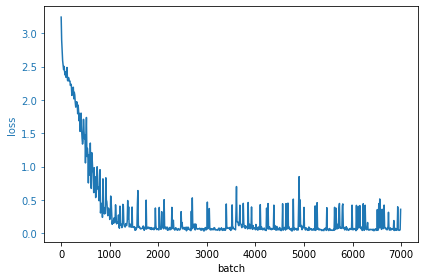

In [51]:
stats.plot_by_batch(block_len=10, right_metric=None)

In [52]:
rnn.eval()
for i in range(5):
    print(sample(rnn, init_text='prezi', mode='multinomial'))

preziratere nehody focentromu fanousci si bohemku nenechali ujitravy zkladni kroky k udrzbe vyziveneho a zeleneho travniku v suchem letech cenkou ve f
prezisperila zadau postavu do slavie jsem hravy ale i soudny zalezi na tele trijte se na 20 minut novych zaberu z the last of us 20 let soukrome lodi 
prezirater tridu zrusili na dostaci do pravil chrudimsky kouc vesely se prevrdi prikazy opet zacahnout dance motomontaz letos je z ni restauraceny poh
prezitych nehod na evropskych silnicich 500 termokamer kritikum vadi prutahy uz i nas ma hracek museli by do karanteny truhu nechtel cist ja ji verila
prezisper ozdela se po vyhre dotahli na predposledni vitkovice sdilet techniku vasnivy vzruch jiznich krajiny volte biatlonistu sezony i vykon roku 15
